# Logistic regression with categorical variables
## Reference categories and odds ratios

You've probably arrived at this notebook becuase you've read my article on Medium (https://medium.com/@lucydickinson/how-to-interpret-the-odds-ratio-with-categorical-variables-in-logistic-regression-5bb38e3fc6a8) about interpretting odds ratios of categorical variables and learning how to work with reference categories, so welcome! 

In this example, I've used an open-source dataset of bike trips with NYC Citibike data (https://www.kaggle.com/datasets/gabrielramos87/bike-trips) and added plenty of derived categorical variables to play with. From the trip duration feature, I've generated a boolean target variable denoting whether a bike trip exceeded 20 minutes or not which I've arbitrarily decided is a 'long' trip. We’ll be looking at which categorical features significantly increase or decrease the odds of a bike trip exceeding 20 minutes.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# import data

df = pd.read_csv('New York Citibike Trips.csv')
df.head(10)

,start_time,stop_time,start_station_id,start_station_name,end_station_id,end_station_name,user_type,bike_id,gender,age,trip_duration
0,2018-05-31 23:59:59,2018-06-01 00:12:57,312,Allen St & Stanton St,460,S 4 St & Wythe Ave,Subscriber,25805,male,32,12.97
1,2018-05-31 23:59:59,2018-06-01 00:12:26,401,Allen St & Rivington St,360,William St & Pine St,Subscriber,17258,male,24,12.45
2,2018-05-31 23:59:51,2018-06-01 00:08:09,483,E 12 St & 3 Ave,368,Carmine St & 6 Ave,Subscriber,19692,male,39,8.28
3,2018-05-31 23:59:48,2018-06-01 00:07:33,3107,Bedford Ave & Nassau Ave,3076,Scholes St & Manhattan Ave,Subscriber,28285,male,28,7.75
4,2018-05-31 23:59:45,2018-06-01 00:07:48,3341,Central Park West & W 102 St,3400,E 110 St & Madison Ave,Subscriber,21000,female,51,8.05
5,2018-05-31 23:59:43,2018-06-01 00:16:10,3562,Classon Ave & St Marks Ave,3562,Classon Ave & St Marks Ave,Subscriber,32205,male,25,16.43
6,2018-05-31 23:59:43,2018-06-01 00:02:52,479,9 Ave & W 45 St,3635,W 36 St & 9 Ave,Subscriber,31327,male,34,3.15
7,2018-05-31 23:59:41,2018-06-01 00:10:12,128,MacDougal St & Prince St,308,St James Pl & Oliver St,Subscriber,20826,male,32,10.52
8,2018-05-31 23:59:38,2018-06-01 00:03:14,537,Lexington Ave & E 24 St,546,E 30 St & Park Ave S,Subscriber,31641,male,37,3.60
9,2018-05-31 23:59:31,2018-06-01 00:21:29,322,Clinton St & Tillary St,3396,Clinton St & 4 Place,Subscriber,33003,male,48,21.97


In [3]:
# drop features not of interest

df = df.drop(['start_station_id', 'start_station_name', 'end_station_id', 'end_station_name', 'bike_id'], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595334 entries, 0 to 1595333
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   start_time     1595334 non-null  object 
 1   stop_time      1595334 non-null  object 
 2   user_type      1595334 non-null  object 
 3   gender         1595334 non-null  object 
 4   age            1595334 non-null  int64  
 5   trip_duration  1595334 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 73.0+ MB


In [5]:
df['start_time'] = pd.to_datetime(df['start_time'])  # converting start time to datetime data type

In [6]:
#  create target variable - derived from trip_duration

df['trip_long'] = np.where(df['trip_duration']>20, 1, 0)  # if the trip is over 20 mins, flag as a 'long'
df

,start_time,stop_time,user_type,gender,age,trip_duration,trip_long
0,2018-05-31 23:59:59,2018-06-01 00:12:57,Subscriber,male,32,12.97,0
1,2018-05-31 23:59:59,2018-06-01 00:12:26,Subscriber,male,24,12.45,0
2,2018-05-31 23:59:51,2018-06-01 00:08:09,Subscriber,male,39,8.28,0
3,2018-05-31 23:59:48,2018-06-01 00:07:33,Subscriber,male,28,7.75,0
4,2018-05-31 23:59:45,2018-06-01 00:07:48,Subscriber,female,51,8.05,0
...,...,...,...,...,...,...,...
1595329,2018-05-01 00:01:00,2018-05-01 00:08:02,Subscriber,male,32,7.02,0
1595330,2018-05-01 00:00:43,2018-05-01 00:05:40,Subscriber,male,33,4.95,0
1595331,2018-05-01 00:00:40,2018-05-01 00:08:03,Subscriber,male,49,7.38,0
1595332,2018-05-01 00:00:35,2018-05-01 00:12:16,Subscriber,male,22,11.67,0


In [7]:
#  create other features

df['under30years'] = np.where(df['age']<30, 'under30', 'over30')  # if the age is under 30, flag as a 'under30'
df['weekday'] = df['start_time'].dt.day_name()
temp = df['weekday'].map({'Monday':'Weekday', 'Tuesday':'Weekday', 'Wednesday':'Weekday', 'Thursday':'Weekday', 
                             'Friday':'Weekday', 'Saturday':'Weekend', 'Sunday':'Weekend'})
df.insert(6, 'daytype', temp)

del temp

In [8]:
# drop left over features not of interest
df = df.drop(['start_time', 'stop_time', 'age'], axis=1)
df

,user_type,gender,trip_duration,daytype,trip_long,under30years,weekday
0,Subscriber,male,12.97,Weekday,0,over30,Thursday
1,Subscriber,male,12.45,Weekday,0,under30,Thursday
2,Subscriber,male,8.28,Weekday,0,over30,Thursday
3,Subscriber,male,7.75,Weekday,0,under30,Thursday
4,Subscriber,female,8.05,Weekday,0,over30,Thursday
...,...,...,...,...,...,...,...
1595329,Subscriber,male,7.02,Weekday,0,over30,Tuesday
1595330,Subscriber,male,4.95,Weekday,0,over30,Tuesday
1595331,Subscriber,male,7.38,Weekday,0,over30,Tuesday
1595332,Subscriber,male,11.67,Weekday,0,under30,Tuesday


Now we have a simple dataset with 5 categorical variables (user_type, gender, daytype, under30(years), weekday) and one target variable of trip_long, which is a bool for whether the trip exceeded 30 minutes or not

In [9]:
#  function to count categorical data within each column and calculate representative percentage
#  this will be useful to decide upon reference categories for dummy variables

def value_counts(data):
    for i, j in data.iteritems():
        v = data[i].value_counts().sort_values(ascending=False)
        v_perc = np.round(100*(data[i].value_counts(normalize=True)).rename('Percentage'), decimals=2)
        v_all = pd.concat([v, v_perc], axis=1)
        print(f'{i},\n\n{v_all}\n')

value_counts(df)

user_type,

            user_type  Percentage
Subscriber    1521005       95.34
Customer        74329        4.66

gender,

         gender  Percentage
male    1179757       73.95
female   415577       26.05

trip_duration,

           trip_duration  Percentage
1.02                 293        0.02
1.03                 248        0.02
1.05                 302        0.02
1.07                 313        0.02
1.08                 294        0.02
...                  ...         ...
74217.25               1        0.00
76709.70               1        0.00
86384.02               1        0.00
111105.53              1        0.00
111781.68              1        0.00

[9106 rows x 2 columns]

daytype,

         daytype  Percentage
Weekday  1330973       83.43
Weekend   264361       16.57

trip_long,

   trip_long  Percentage
0    1273547       79.83
1     321787       20.17

under30years,

         under30years  Percentage
over30        1163107       72.91
under30        432227       27.09

w

Let's explore the data visually to get an understanding of the distribution of certain feature categories within the data. Below is an example of the kind of thing you could investigate. I've visualised the data by looking at the proportion of long and short trips per the feature 'weekday' and its categories.

In [10]:
# Visualisation prep

# creating grouped dataframe per weekday
df['trip_short'] = np.where(df['trip_long']==0, 1, 0)
df_weekday = df.groupby('weekday')[['trip_long', 'trip_short']].sum().reset_index()
df_weekday.index = df_weekday['weekday']
df_weekday = df_weekday.drop('weekday', axis=1)

# creating dataframe of proportions of long/short rides
df_weekday_prop = df_weekday.copy()
df_weekday_prop['total'] = df_weekday_prop['trip_short'] + df_weekday_prop['trip_long']
df_weekday_prop['trip_short%'] = np.round(100*(df_weekday_prop['trip_short']/df_weekday_prop['total']), 2)
df_weekday_prop['trip_long%'] = np.round(100*(df_weekday_prop['trip_long']/df_weekday_prop['total']), 2)
df_weekday_prop = df_weekday_prop.drop(['trip_long', 'trip_short', 'total'], axis=1)
df_weekday_prop = df_weekday_prop.reindex(index = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
df_weekday_prop

,trip_short%,trip_long%
weekday,,
Monday,78.62,21.38
Tuesday,80.42,19.58
Wednesday,80.22,19.78
Thursday,81.18,18.82
Friday,79.76,20.24
Saturday,77.35,22.65
Sunday,79.40,20.60


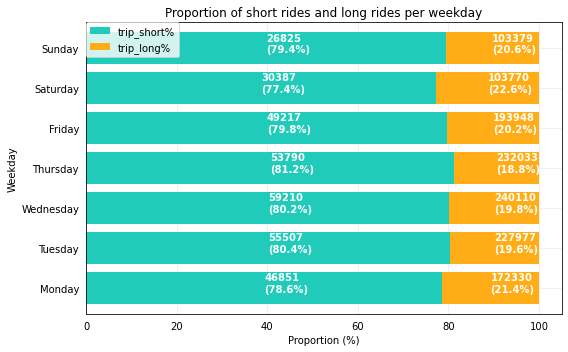

In [11]:
# Visualisation

fig, ax = plt.subplots(figsize = (8, 5))

colors = ['#21cbba', '#ffac16']

df_weekday_prop.plot(kind='barh', stacked=True, width=0.8, ax=ax, color=colors)

ax.set_ylabel("Weekday")
ax.set_xlabel("Proportion (%)")

ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(True, color='#EEEEEE')

for n, x in enumerate([*df_weekday_prop.index.values]):
    for (proportion, count, y_loc) in zip(df_weekday_prop.loc[x],
                                          df_weekday.loc[x],
                                          df_weekday_prop.loc[x].cumsum()):
        #print(proportion, count, y_loc)

        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.1,
                 s=f'{count}\n({np.round(proportion, 1)}%)', 
                 color="white",
                 fontsize=10,
                 fontweight="bold")


plt.title('Proportion of short rides and long rides per weekday')
plt.legend(loc='upper left', borderaxespad=0)

fig.tight_layout()
plt.show()

In [12]:
#  LOGISTIC REGRESSION

"""
      NOTE. 
      this notebook is a quick guide for reference categories 
      and understanding odds ratios, hence I am going to skip 
      the usual machine learning steps such as test/train 
      split as I am not focussing on assessing or improving 
      model accuracy.
      
"""

# split into predictor and target dataset

y = df['trip_long']
X = df.drop(['trip_long', 'trip_short', 'trip_duration'], axis=1)
X

,user_type,gender,daytype,under30years,weekday
0,Subscriber,male,Weekday,over30,Thursday
1,Subscriber,male,Weekday,under30,Thursday
2,Subscriber,male,Weekday,over30,Thursday
3,Subscriber,male,Weekday,under30,Thursday
4,Subscriber,female,Weekday,over30,Thursday
...,...,...,...,...,...
1595329,Subscriber,male,Weekday,over30,Tuesday
1595330,Subscriber,male,Weekday,over30,Tuesday
1595331,Subscriber,male,Weekday,over30,Tuesday
1595332,Subscriber,male,Weekday,under30,Tuesday


In [13]:
#  selecting reference categories and creating dummy variables

def ref_cats(data, list_obj):
    
    """
    Function to identify and slice the category of 
    each variable that is the most representative 
    in the dataset. To be used in manually dropping 
    fields afer running pd.get_dummies and not using 
    drop_first argument.
    ________________________________________________
    
    Args:
        data: feature dataframe
        list_obj: empty list object that needs to be defined
                  prior to the function
               
    Returns:
        list_obj: list containing most common categories per
                  variable 
        
    """
    
    for i, j in data.iteritems():
        v = data[i].value_counts().sort_values(ascending=False).index.tolist()[0]  # slicing the top category per feature
        ref_cat = i + '_'+ str(v)  # prefixing the category name with the feature name in line with dummy variable naming convention
        list_obj.append(ref_cat)  # appending each top category to a list
    print(list_obj)

cat_list=[] # initialise empty list to store category values
ref_cats(X, cat_list)    

X_dummy = pd.get_dummies(X)  #  we’re not using the drop_first argument here. The default is False.
X_dummy = X_dummy.drop(cat_list, axis=1)  #  drop the reference categories stored in the list
X_dummy

#  let’s check the right number of variables have been dropped
print(f'Before: ', X.shape)
print(f'After: ', X_dummy.shape)


['user_type_Subscriber', 'gender_male', 'daytype_Weekday', 'under30years_over30', 'weekday_Wednesday']
Before:  (1595334, 5)
After:  (1595334, 10)


In [14]:
#  statsmodels logistic regression

logreg = sm.Logit(y, sm.add_constant(X_dummy)).fit_regularized() #  sm.add_constant(X_ass), method='bfgs'
#print(logreg.params)
print(logreg.summary())

#  calculating odds ratios and displaying in dataframe

pd.set_option('display.float_format', lambda x: '%0.3f' % x)  # suppress scientific notation

coefs = pd.DataFrame({
    'coef': logreg.params.values,
    'odds ratio': np.exp(logreg.params.values),
     'p-values': logreg.pvalues
})
coefs

C:\Users\lucy_dickinson\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4863320867088121
            Iterations: 58
            Function evaluations: 58
            Gradient evaluations: 58
                           Logit Regression Results                           
Dep. Variable:              trip_long   No. Observations:              1595334
Model:                          Logit   Df Residuals:                  1595323
Method:                           MLE   Df Model:                           10
Date:                Thu, 15 Sep 2022   Pseudo R-squ.:                 0.03267
Time:                        14:51:22   Log-Likelihood:            -7.7586e+05
converged:                       True   LL-Null:                   -8.0207e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

,coef,odds ratio,p-values
const,-1.546,0.213,0.000
user_type_Customer,1.664,5.282,0.000
gender_female,0.321,1.378,0.000
daytype_Weekend,0.003,1.003,1.000
under30years_under30,-0.078,0.925,0.000
weekday_Friday,-0.004,0.996,0.551
weekday_Monday,0.055,1.057,0.000
weekday_Saturday,0.040,1.041,1.000
weekday_Sunday,-0.043,0.958,1.000
weekday_Thursday,-0.065,0.937,0.000


#### Quick recap of odds ratios:

The odds ratio is the ratio or comparison between two odds to see how they change given a different situation or condition. The odds ratio for a feature is a ratio of the odds of a bike trip exceeding 20 minutes in condition 1 compared with the odds of a bike trip exceeding 20 minutes in condition 2.  

For categorical features or predictors, the odds ratio compares the odds of the event occurring for each category of the predictor relative to the reference category, given that all other variables remain constant.

#### Some interpretations

The p values guide us through which categories are significant (<.05) or not, but in a nutshell:

The odds of a ride exceeding 20 minutes is 5 times higher if you’re a customer than a subscriber, if all other variables are constant, given an odds ratio of 5.28. (Maybe they’re making the most out of their ride given they’re not a regular paying subscriber!)

The odds of a ride exceeding 20 minutes is 37% higher if you’re a female compared with a male, if all other variables are constant, given an odds ratio of 1.37.

The odds of a ride exceeding 20 minutes is 8% lower if you’re under 30 years in age compared with someone who is over 30, if all other variables are constant,  given an odds ratio of 0.92.

The odds of a ride exceeding 20 minutes barely changes on a weekday or weekend, if all other variables are constant, given an odds ratio of 1.003.


##### There we have it - thanks very much for reading and hope it helped. If you have any questions or ammendments then please reach out :)